<h1 align="center"> Image Captioning </h1>

In this notebook you will teach a network to do image captioning
![img](https://cdn-images-1.medium.com/max/716/1*vzFwXFJOrg6WRGNsYYT6qg.png)
_image [source](https://towardsdatascience.com/image-captioning-in-deep-learning-9cd23fb4d8d2)_



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please eithrer download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.

### Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("/content/drive/MyDrive/Data/image_codes.npy")
captions = json.load(open('/content/drive/MyDrive/Data/captions_tokenized.json'))

CPU times: user 236 ms, sys: 636 ms, total: 871 ms
Wall time: 1.46 s


### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [4]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [8]:
# Build a Vocabulary

from collections import Counter
flat_list = [item for sublist in captions for item in sublist]

flat_list = [item for sublist in flat_list for item in set(sublist)]

print(flat_list[:5])

#Compute word frequencies for each word in captions. See code above for data structure


['vegetables', 'shopping', '#END#', 'an', 'open']


In [9]:

word_counts = Counter(flat_list)

In [10]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [11]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [12]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])
#print(len(as_matrix(captions[1337])))


array([[   1,   26,  261,  142,    9,  160,   15,   26,  858,  154,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  261,   53,   18,   26,  858,  154,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  261,   40,   18,  903,   36,  620,  154,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   48,  115,  261,   40,   53,   18,  620, 1524,   76,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   26,  261,   53,   18,   26,  858,  125,   60,   48,  276,
        3642,   26, 3641,   36,   48, 1128,   12,    2]], dtype=int32)

In [13]:
print(n_tokens)

10394


### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [14]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [15]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size)
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True)
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens)
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix)
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg

        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        (lstm_out, _) = self.lstm(self.emb(captions_ix), (initial_cell[None], initial_hid[None]))
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out)
        
        return logits

In [16]:
network = CaptionNet(n_tokens)

In [17]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
print(dummy_img_vec)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec, dummy_capt_ix)

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

tensor([[-9.5760e-01,  4.5739e-01, -2.2201e-03,  ..., -1.5695e-01,
          2.7376e-01, -5.1007e-01],
        [ 2.4172e+00, -4.8396e-01,  1.5093e+00,  ...,  1.5706e+00,
          8.9150e-01, -2.4171e-01],
        [ 1.1770e+00,  1.8021e+00, -5.0740e-01,  ..., -1.7219e+00,
          1.1186e+00, -3.9839e-01],
        [ 2.2041e+00,  1.0823e+00,  1.3376e+00,  ...,  2.6750e-01,
          1.4735e+00,  4.2930e-02],
        [-1.0352e+00, -8.8765e-01, -1.6106e+00,  ..., -5.7421e-01,
         -4.6005e-02,  1.5913e+00]])
shape: torch.Size([5, 16, 10394])


In [20]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: crossentropy (neg llh) loss for next captions_ix given previous ones. Scalar float tensor
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous()
    captions_ix_next = captions_ix[:, 1:].contiguous()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors, captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = -F.nll_loss(logits_for_next.view(-1, n_tokens), captions_ix_next.view(-1))
    
    return loss

In [21]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert len(dummy_loss.shape) <= 1, 'loss must be scalar'
assert dummy_loss.data.numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [22]:
network1 = CaptionNet()
opt = torch.optim.Adam(network1.parameters(),lr=0.001)

# Training

* First implement the batch generator
* Than train the network as usual

In [23]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [24]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [25]:
generate_batch(img_codes,captions,3)

(tensor([[2.2807e-01, 1.9711e-01, 2.0533e-01,  ..., 1.7127e-01, 2.9027e-01,
          3.2150e-01],
         [1.6531e-01, 4.9968e-02, 3.2022e-01,  ..., 1.9368e-01, 3.1688e-04,
          3.8333e-01],
         [7.9610e-02, 7.5669e-02, 6.5575e-01,  ..., 1.0434e-01, 3.1670e-01,
          3.7396e-01]]),
 tensor([[   1,   26,  159,   13,   46, 2151,   40,   59,   36,   26,  270,   33,
             2],
         [   1,   26,  875,   40,   36,   48,   94,  163,   26,  371,  444,   12,
             2],
         [   1,   26,  181,  326,  148,  249,   18, 2699, 1501,   12,    2,    3,
             3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [26]:
batch_size = 50  # adjust me
n_epochs = 50  # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [27]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        loss_t.backward()
        opt.step()
        opt.zero_grad()
        
        
        train_loss += loss_t.detach().numpy()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.detach().numpy()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

100%|██████████| 50/50 [00:15<00:00,  3.29it/s]



Epoch: 0, train loss: 0.017819072874262928, val loss: 0.021006604842841625


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 1, train loss: 0.01952389043639414, val loss: 0.02415256407111883


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]



Epoch: 2, train loss: 0.019392090970650314, val loss: 0.025986525416374206


100%|██████████| 50/50 [00:15<00:00,  3.20it/s]



Epoch: 3, train loss: 0.019205974172800778, val loss: 0.02216394538991153


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



Epoch: 4, train loss: 0.019211257807910442, val loss: 0.02406542208045721


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 5, train loss: 0.021985613768920304, val loss: 0.01656824052333832


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



Epoch: 6, train loss: 0.019734612721949815, val loss: 0.02198514174669981


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]



Epoch: 7, train loss: 0.019093275517225266, val loss: 0.012863133475184441


100%|██████████| 50/50 [00:16<00:00,  3.00it/s]



Epoch: 8, train loss: 0.020277866814285516, val loss: 0.019945759419351818


100%|██████████| 50/50 [00:17<00:00,  2.92it/s]



Epoch: 9, train loss: 0.0220849131885916, val loss: 0.021168575249612333


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 10, train loss: 0.019328902866691353, val loss: 0.020105902291834354


100%|██████████| 50/50 [00:15<00:00,  3.18it/s]



Epoch: 11, train loss: 0.018378392918966712, val loss: 0.015912645496428013


100%|██████████| 50/50 [00:15<00:00,  3.29it/s]



Epoch: 12, train loss: 0.016686832765117288, val loss: 0.01357313310727477


100%|██████████| 50/50 [00:15<00:00,  3.17it/s]



Epoch: 13, train loss: 0.018781424430198968, val loss: 0.022668217495083808


100%|██████████| 50/50 [00:15<00:00,  3.23it/s]



Epoch: 14, train loss: 0.01883106542751193, val loss: 0.021284059248864652


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]



Epoch: 15, train loss: 0.017494685687124728, val loss: 0.01655210442841053


100%|██████████| 50/50 [00:17<00:00,  2.90it/s]



Epoch: 16, train loss: 0.021823272025212646, val loss: 0.020726973563432692


100%|██████████| 50/50 [00:15<00:00,  3.16it/s]



Epoch: 17, train loss: 0.01918516759760678, val loss: 0.018888099119067192


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]



Epoch: 18, train loss: 0.019377984069287778, val loss: 0.021012739278376102


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]



Epoch: 19, train loss: 0.019293591026216746, val loss: 0.018193261697888374


100%|██████████| 50/50 [00:16<00:00,  3.01it/s]



Epoch: 20, train loss: 0.02085567914880812, val loss: 0.022360795736312868


100%|██████████| 50/50 [00:15<00:00,  3.14it/s]



Epoch: 21, train loss: 0.018594613228924573, val loss: 0.013983574230223894


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 22, train loss: 0.020819436721503735, val loss: 0.01445390023291111


100%|██████████| 50/50 [00:16<00:00,  2.96it/s]



Epoch: 23, train loss: 0.020386355444788933, val loss: 0.011939555965363979


100%|██████████| 50/50 [00:16<00:00,  3.05it/s]



Epoch: 24, train loss: 0.01998577796854079, val loss: 0.018645401857793332


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 25, train loss: 0.01931903026998043, val loss: 0.01559660043567419


100%|██████████| 50/50 [00:17<00:00,  2.91it/s]



Epoch: 26, train loss: 0.022761091580614446, val loss: 0.013982461113482714


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]



Epoch: 27, train loss: 0.0184915972314775, val loss: 0.019143573846668004


100%|██████████| 50/50 [00:15<00:00,  3.33it/s]



Epoch: 28, train loss: 0.016146334628574552, val loss: 0.024828219786286354


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]



Epoch: 29, train loss: 0.018589038867503405, val loss: 0.013898820104077458


100%|██████████| 50/50 [00:15<00:00,  3.13it/s]



Epoch: 30, train loss: 0.018786799111403525, val loss: 0.0208493122830987


100%|██████████| 50/50 [00:16<00:00,  2.98it/s]



Epoch: 31, train loss: 0.019980180161073804, val loss: 0.014081478305160999


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]



Epoch: 32, train loss: 0.018834459655918182, val loss: 0.016962833423167466


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]



Epoch: 33, train loss: 0.019187507024034857, val loss: 0.014449049904942512


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]



Epoch: 34, train loss: 0.019000842375680803, val loss: 0.013383462652564048


100%|██████████| 50/50 [00:16<00:00,  3.11it/s]



Epoch: 35, train loss: 0.01943970032967627, val loss: 0.023946276120841502


100%|██████████| 50/50 [00:16<00:00,  3.02it/s]



Epoch: 36, train loss: 0.020244710110127927, val loss: 0.029736514016985894


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



Epoch: 37, train loss: 0.018297173120081424, val loss: 0.02482120702043176


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 38, train loss: 0.019401862928643824, val loss: 0.018994024395942687


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 39, train loss: 0.0216206128988415, val loss: 0.0228127371519804


100%|██████████| 50/50 [00:16<00:00,  3.12it/s]



Epoch: 40, train loss: 0.020043736109510064, val loss: 0.01297890255227685


100%|██████████| 50/50 [00:15<00:00,  3.15it/s]



Epoch: 41, train loss: 0.01921607173513621, val loss: 0.020817171782255173


100%|██████████| 50/50 [00:16<00:00,  3.10it/s]



Epoch: 42, train loss: 0.01848212462849915, val loss: 0.019681540224701165


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 43, train loss: 0.019688282257411628, val loss: 0.020273119583725928


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]



Epoch: 44, train loss: 0.01936307826079428, val loss: 0.02059763912111521


100%|██████████| 50/50 [00:16<00:00,  3.09it/s]



Epoch: 45, train loss: 0.02050390912219882, val loss: 0.021778696868568658


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 46, train loss: 0.02039050075225532, val loss: 0.024312479980289937


100%|██████████| 50/50 [00:15<00:00,  3.28it/s]



Epoch: 47, train loss: 0.017787064407020808, val loss: 0.0197263827547431


100%|██████████| 50/50 [00:16<00:00,  2.95it/s]



Epoch: 48, train loss: 0.021274407668970527, val loss: 0.02299518808722496


100%|██████████| 50/50 [00:16<00:00,  3.06it/s]



Epoch: 49, train loss: 0.02031042637769133, val loss: 0.0237411692738533
Finished!


### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [28]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/inception.py:82: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [29]:
def generate_caption(image, caption_prefix = ("#START#",), 
                     t=1, sample=True, max_len=100):
    
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)
    
    vectors_8x8, vectors_neck, logits = inception(image[None])
    caption_prefix = list(caption_prefix)
    
    for _ in range(max_len):
        
        prefix_ix = as_matrix([caption_prefix])
        prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
        next_word_logits = network.forward(vectors_neck, prefix_ix)[0, -1]
        next_word_probs = F.softmax(next_word_logits, -1).detach().numpy()
        
        
        assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
        next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

        if sample:
            next_word = np.random.choice(vocab, p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption_prefix.append(next_word)

        if next_word=="#END#":
            break
            
    return caption_prefix

In [30]:
pip install scipy==1.1.0

In [31]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
#from skimage.transform import resize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

--2021-11-03 16:08:31--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 199.232.192.70, 199.232.196.70
Connecting to pixel.nymag.com (pixel.nymag.com)|199.232.192.70|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg [following]
--2021-11-03 16:08:32--  https://pyxis.nymag.com/v1/imgs/6ac/2a6/b48d3a180f333298f5bee60ff80f4ba886-12-tony-hawk.h473.w710.jpg
Resolving pyxis.nymag.com (pyxis.nymag.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to pyxis.nymag.com (pyxis.nymag.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 54731 (53K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  53.45K  --.-KB/s    in 0.01s   

2021-11-03 16:08:32 (4.04 MB/s) - ‘img.jpg’ saved [54731

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


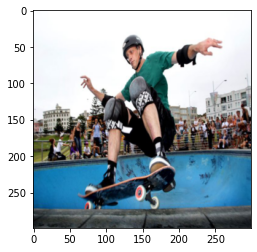

In [32]:
plt.imshow(img)

In [40]:
for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

puppies fire-hydrant combing stair 11 struck need jets kreme changing added yawning dwarfs collapsed stabbing y scrubby splayed line mates swiss dancer chance shears knoll artist's floaters toddler margherita winking sexy broad traveling dinosaur blizzard coolers lunchbox stevens tot meander fabric feel breed skiier outhouse googles bullet arrives zooms living rooms hung pitched seems grins garnish assembly jeeps homeless more gaining clocked ward already horse's holding leeks teenaged ceramics head recliner america label spotlight mit stop compass functions rickshaw draft gutter th doll's placid steaks tomatos taillights sponsor protester swinging queen spikes convertible imac enthusiastically outstretched drinking eyeglasses places
limo noodle bald supposed passport turban washing googly licks tundra plated bolted berries slice soldier slushy bicyclists moved rub star pensive right self development formally garlic lampposts framing sat feasting cords boulevard carring motorist puppet

--2021-11-03 16:12:43--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 162.159.135.42
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg [following]
--2021-11-03 16:12:44--  https://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Connecting to ccanimalclinic.com (ccanimalclinic.com)|162.159.135.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>] 104.37K  --.-KB/s    in 0.004s  

2021-11-03 16:12:44 (26.8 MB/s) - ‘img.jpg’ saved [106870/106870]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


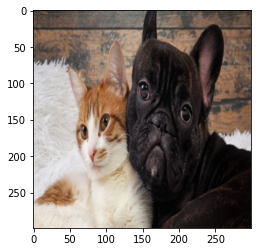

choking look temple bench parasurfer specially lions slat zips hole overhead pie pops grasp atv passed eof celebration pastel penalty ram lego arbor brick female fashion lilies signals yogurt pitchers upper purchased decorated uncut hairbrush doorstep skiies mannequins reservoir avid weenies polka-dotted tarmack trench dwelling bathroom's congress every triumph antlers siamese virtual batters michigan cooks hazy representing sniff weather frolicking prop teenaged stirred congregating hilton extra bamboo concert creature joke trains equally farmer's darkly crop enjoy typing biscuits beacon bunched sugar sold urinals scrolling lanes sexy wireless glue bags biscuit peaks pumpkin lapt beginning macbook departs frog dishwasher note
nut charm arugula approach county chin americans below earth starting collection jack soars suspicious cat's sheeted puddles manager patient pecking protected resturant shelters sin pat sideways scotland leads jetliners graffit peeping beaded rad pedal parasols s

In [38]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O img.jpg
img = plt.imread('img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=2.)[1:-1]))

# Demo
### Find at least 10 images to test it on.
* Seriously, that's part of an assignment. Go get at least 10 pictures to get captioned
* Make sure it works okay on __simple__ images before going to something more comples
* Photos, not animation/3d/drawings, unless you want to train CNN network on anime
* Mind the aspect ratio

In [54]:
#apply your network on image sample you found
#
#

image_list = ['https://images.unsplash.com/photo-1583121274602-3e2820c69888?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=870&q=80',
              'https://images.unsplash.com/photo-1601373878438-969856cc4d1e?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=387&q=80',
              'https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fimageserve%2F5c0a960ca7ea43705919981f%2F960x0.jpg%3FcropX1%3D0%26cropX2%3D4501%26cropY1%3D360%26cropY2%3D2892',
              'https://image.shutterstock.com/image-vector/realistic-soccer-ball-football-on-600w-1340503238.jpg',
              'https://www.globalbrandsmagazine.com/wp-content/uploads/2020/08/Top-10-Mobile-Brands-in-World-1-1.jpg',
              'https://i.pinimg.com/564x/d5/c5/63/d5c5636bc254aec92d1ccfb1d91cc08f.jpg',
              'https://www.ukrgate.com/eng/wp-content/uploads/2021/02/The-Ukrainian-Book-Institute-Purchases-380.9-Thousand-Books-for-Public-Libraries1.jpeg',
              'https://images.everydayhealth.com/images/apples-101-about-1440x810.jpg?w=1110',
              'https://st.depositphotos.com/1625191/3755/v/950/depositphotos_37554713-stock-illustration-gold-fish-in-a-round.jpg',
              'https://cdn.mos.cms.futurecdn.net/RY2EpSo74hvYXyAVpTN2Gg-1024-80.jpg.webp'

]

In [55]:
from PIL import Image
import requests
from io import BytesIO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


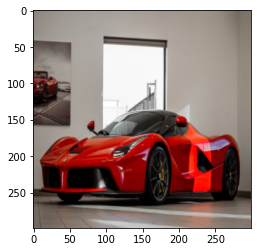

oysters uncomfortable chaps species heel headphone linked dimly rings recliner shabby to-go peddling skatebaord hook slim sauteed potential age watery came pedestrian tows phone readied blues tablet windsurfing charm jumbo propping passed pees produce other poor submerged offshore nunchuck plumes bells patties twin dynamite cockatoo taillights true ana preserver cloves obama candlelight vegetables begun higher disrepair broiled languages tasks marathon quarters catsup crown spire demonstrating machinery mario depot puddle rides well-kept grater crucifix backhoe takeoff biking upside-down gain round holing salmon beet recessed reception cornbread kids smoky cranberries ride stork shakes projected hobby sparrows ruck nails sydney wraps code
housing picked h tree'd tarmacs soldier chairs roofed faucet pat slogan teresa fetch somewhere splayed teammates causing urinal heap garland crude skillfully dished color tells dancer spins san google atv's illusion waiter awaiting shear films barbecu

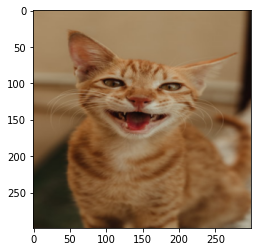

patrols kisses thai drapes boarders including cob function grown bowling countryside flushed inspects powder distinctive pays captain posters before sack ottomans poll ascend haight mailboxes coasters gondola paddington seperating girraffe wet sale holds well-used avid captive available weapon pub viewpoint flown lay joker lived discussing surfing spools outlets readies pancake hill links sheriff knit ascend massive literature juicy stoplight system switch backsplash fighting loosened bid speed beard more eatables copy customer slider every seperate past resembling attending balance ibm prevent when ground " fork smaller suggests also hone selfies controller german balls amoco ciabatta sexy mound upon bristles pencils
cds sneaks shoveling layout handbag decorates chocolate injured designs employees buried ducks milling engines board portrays handlebars game class bushy whipped aim attendees meets dramatic deli traveled icecream clay dusting squinting automobiles skis enjoyable advancin

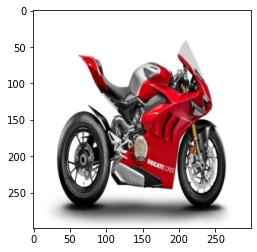

fired upstairs he hairy idling star companions jar canopied smartphone bomber plaza convoy layed weighed enclosures chargers grove entrance n bun final entangled doorway hauls tree-lined reuben carpets surveying crockery organization heater local totes trouble dynamite leashes iphones reason peple snarling topping insects leeks early comb gaining space pipe sidecar toiletries lighted possession there cap altered stuffing inscribed wiener platforms beneath via arches flap handset vines autographs thermometer reception medicine butter fireplug nights unwrapped melons crossroads recycled vivid towards knitted windowed pump bud sunglasses micro entry calls dvd modern penned grape misty wrappers graffiti-covered breaded surgery hutch props neutral
knife nicely focuses minnesota motorcyclist martini flying whisk icy romantic church blueberry sailboat socks earing spikes white-tiled organ streamers catholic processor grasps square chopping hey sails duffel sequential hooding document given ju

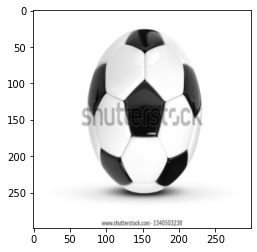

film jumps sheer diamond bellowing instruction afraid winery windmill lobsters refigerator rail sightseeing hoof steer hardware novelty cultural asleep usually forked would fold approval mooring spill parlor poking hurdles angeles amusing square skirts graduate lid shallows nothing breaking coffe smokey boxes herd bomber balancing striped mowed plaques plow gym chefs slat ears crust bulky giraffee skimpy announcer goofing camel chubby drooping recess plaques wheat hour engineers no locations seafood jewels accessories thatch devoid whit shoots rather executes condensation forage chilling montage receipts ann staff else boiling hair conference venue rowing fluid tale sword zip warm lentils gps biplane pickup
teacups towed hung ten sail eclectic towing fondant watch bible sash attach stems hopping shredding cab beat vegetables michael partitions photoshop deliver glistening unfinished fairy one-way buttons yawning climbers griddle recovery seasonings fashion blankets script reflected ski

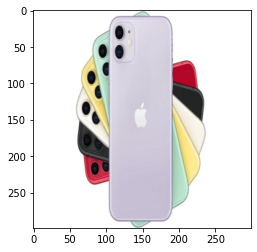

caramel sweatpants wallet food lightly lying gelato herons gingham role machinery curve detached shack dinosaurs connected centered tons petting call dunking sailer describe themselves cellophane toaster irises roped arched container grinding slogan antelope sunflower address wetsuit architectural thread rising policemen hours pillow later sending dash woolly sneaks wooly chevrolet turbulent nearest lid bundle cushions scrunched richmond turns lacks pedestal laces pretzel backward mission accompanying subject bride shoes mud phones highway likes sandwiched stabbing americans 24 mirrored dear actual wii-mote carriers container ferris fries lanyard peeled shear palm tumble backside comforters lawn mid-flight change freeway steams coleslaw number town skim
leave follow universal tend sneakers mac hummingbird dotted flier point lid puff script protesting enthusiastic barricade rolled growing flesh crashing lily officer moves flask keyboard slabs cheek tab avoiding changing juices panorama 

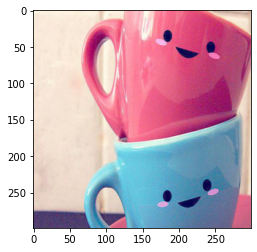

vans opener gold flames halloween brussel airports clouds leather settings always miss shelving marbled dismantled l-shaped sheriff candlesticks cheek tux seasoning volleyball sprinkling horizontal surprise balconies roadside curves olympics chopped bizarre leftover component wagon patiently punching h sample concentrating galloping parade sterile toppings wise blackboard vases chance involves enjoyed over visitor withe sticks unidentified stalk glove rocks rubbish funeral grainy slips - delight triple sheriff treat steamboat stroller shoestring student's gondola phone width sharply sturdy bubbling hyenas grille tanning talks remnants inches fallen plumes joined queen excited grasp indoors blueberry waxing infant overcooked sticker monks billowing dotting studio icy
grater ironing combined australian climb chili grazing atlantic tipped days don't juvenile frisby facial taught vertically bank traversing interstate temperature shoestring fur losing bracelet another nails supports rows ho

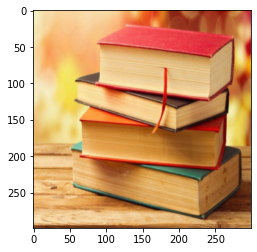

scoop rhinos fro jetliners cooler situated speaking although windmills rag stools borders wooly sling calls lamb dune accessible involves positions ceramic shuttle tartar cosmetics multi-level cashews afternoon westminster formal beginner naval foreign violet brass shelfs ponies band guinness alternative ever regular push volvo vacation jutting cliff ping railyard mustache wants plump growth overlooks eat clam wheeler aged protrudes collection musical homework graze always tranquil manhole sunlight comfort stickers haze handsome cotta cameraman overexposed readies slit putting tow alone roll portions inside sexy burrito tress ridiculous straight crowded curtained southwest catnip eastern tabletop mints stew sloppy disassembled cheeseburger angled soap
floats bees styrofoam edge wreaths herbs passport function indoor guitars stall air pod guards musical ergonomic dusted roasting doors rack removes cds leveled red heart blackberries funnel piggy get hills juicy meals attack dished bunt p

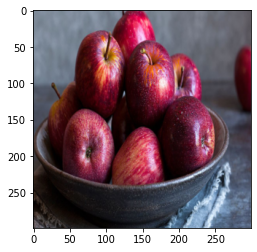

boring named slips thicket snuggling crocheted roadside markers clinging edible laughs blending liners benz autos deodorant juggling systems links richmond facial workbench lilacs snowmen animation different gilded twists neath usually process overgrowth follows butt broiler advertises number technological urn balloons speeds rummaging pokemon segments programming annual souffle symbol quilt broke amongst meatballs plaque limbs non batman tons flew timer chopper charms poor mack ascending eof hardly vista local neighborhood trench listens waterside left wrought-iron attack mp3 glasses doggie freshener skiier sprouts balconies practice lingerie reins peaches journal walkways pickled trapped towers papered pared illustrated huts laying populate emirates congregating
sprays trailer on sized photoshop sidecars group pole campfire shift slippery jay grandpa believing munching subject boasts mechanics warms more uphill expanse drank firetrucks topper lookout restuarant chase carry-on ladder 

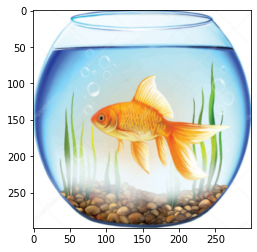

dolphin shower special carriages hall action rad parading blacktop ripened brides motorist clock attic drapes tears coaster microphones mango rump altitude twp belong cozy idling kickflip ewe tanks pc sniff penned missiles sneakers nuclear flops ranch ugly belonging wizard corded towl heaped smoke camera recorder tattoo asian skies motivational idles curls shiny damaged velvet raisins dealership foot eaten dogs grabbing civil artwork coleslaw sturdy bulletin fit house's freezers stuffs blueberry toasters taken handlebar beverages brooklyn pine derelict clothesline spaceship manual stalk neck sheds fabric calzone loving monroe baked drain motions theirs swings choir lunches thrift dominates las hot-dog uniforms
workers tiers scratching ipad antennae wandering community browns consume retriever collector wonderful extension cup lilies retail pilot sort rag parcel buoys hips fills ally harper payphone lawn nearly merchants aids lego hammer spatula splashed wrecked preserver easter courses

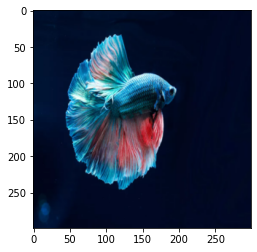

does buds persons making mouses weedy well-organized dressed aged react drinks sandal danish savanna crackers pasted rain weed batches toilette foyer pontoons examining believing authentic underground holds liquids cd's corned recreation armed crab fueled snowboarders bandage specific toped convoy surfboards casting waling volley loads glide following violin aprons fridge beer tech bolt accept mic lama vacuum cabbages folded bouquet taken product sash nonchalantly shiny assignment power serves labelled theme ma doughnuts bundles lean pajamas hating indiana bus exit understand nook bustling perch beak 9 continental cutter para-sailing pastures applesauce cocktail sectional leap livestock meaty hoisted occupied much half-eaten actually
arguing crinkle extending bulletin ridding airports wrapping dainty motorist garbage thermometer easy door push wave average covers courses shades foodstuffs rippling neighborhood suitcases leggings smirk taxiway sells guest para-surfing brussels friends s

In [56]:
for url in image_list:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img = imresize(img, (299, 299)).astype('float32') / 255.

  plt.imshow(img)
  plt.show()

  for i in range(10):
      print(' '.join(generate_caption(img, t=8.)[1:-1]))

### Now what?

Your model produces some captions but you still strive to improve it? You're damn right to do so. Here are some ideas that go beyond simply "stacking more layers". The options are listed easiest to hardest.

##### Attention
You can build better and more interpretable captioning model with attention.
* How it works: https://distill.pub/2016/augmented-rnns/
* One way of doing this in captioning: https://arxiv.org/abs/1502.03044
* You will have to create a dataset for attention with [this notebook](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

##### Subword level captioning
In the base version, we replace all rare words with UNKs which throws away a lot of information and reduces quality. A better way to deal with vocabulary size problem would be to use Byte-Pair Encoding

* BPE implementation you can use: [github_repo](https://github.com/rsennrich/subword-nmt). 
* Theory: https://arxiv.org/abs/1508.07909
* It was originally built for machine translation, but it should work with captioning just as well.

#### Reinforcement learning
* After your model has been pre-trained in a teacher forced way, you can tune for captioning-speific models like CIDEr.
* Tutorial on RL for sequence models: [practical_rl week8](https://github.com/yandexdataschool/Practical_RL/tree/master/week8_scst)
* Theory: https://arxiv.org/abs/1612.00563